<a href="https://colab.research.google.com/github/yugant99/interaction_app/blob/main/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

About The Data ::

Technical indicators (RSI, MACD, Bollinger Bands)
Price movement patterns (Price_Change features, lagged close prices)
Pattern recognition (double_top, double_bottom, head_shoulders)
Support/resistance levels
Market calendar features (earnings seasons, holidays)
Interaction terms between volume and price features


Why The Feature Engineering:
Key Feature Groups for Mean Reversion

Oscillator Indicators (RSI, Stochastic %K, %D)

These are crucial for mean reversion as they explicitly measure overbought/oversold conditions
RSI values above 70 or below 30 often signal potential reversals
Research shows these indicators have higher predictive power for mean reversion than trend-following indicators


Bollinger Bands (BB_Middle, BB_Lower)

The middle band represents the moving average (the "mean")
Deviations outside the bands often revert back to the middle
The distance between price and middle band is a direct measurement of potential reversion strength


Price Change Ratios (ratio_Price_Change features)

These capture the acceleration or deceleration of price movements
Mean reversion often occurs after rapid price changes in one direction


Pattern Recognition Features (double_top, double_bottom)

These chart patterns historically precede reversals
Adding these boolean features allows the model to learn from historical pattern effectiveness


Why Actor-Critic for Mean Reversion Trading?

Continuous Action Space Handling

Unlike Q-learning, Actor-Critic can handle continuous action spaces (like position sizing)
This allows for more nuanced trading decisions beyond simple buy/sell/hold


Balance Between Stability and Sample Efficiency

The critic provides value estimates that reduce variance in policy updates
Policy gradients from the actor enable sample-efficient learning
This balance is crucial when working with financial time series


Separate Policy and Value Networks

The actor network can focus on learning the optimal trading policy
The critic network evaluates the expected returns of states and actions
This separation improves learning stability compared to pure policy gradient methods



Why Actor-Critic Over Other Deep RL Approaches
The mean reversion strategy particularly benefits from Actor-Critic compared to other reinforcement learning approaches because:

DQN (Deep Q-Networks) - limited to discrete actions, not ideal for position sizing
DDPG (Deep Deterministic Policy Gradient) - lacks exploration in stochastic environments like stock markets
PPO (Proximal Policy Optimization) - on-policy method requiring more samples
Actor-Critic - balances exploration/exploitation, handles continuous actions, and is more sample-efficient


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/StockMarketPredictor/final_csv.csv')
df.head()

,interact_OBV_Close_days_to_next_holiday,interact_OBV_Close_days_from_last_holiday,MACD,%K,%D,Price_Change_10,interact_OBV_Close_is_earnings_season,Close_Lag_2,Price_Change_5,diff_MACD_Signal_Line,...,head_shoulders,ratio_Price_Change_1_Price_Change_5,is_resistance,double_bottom,ratio_Price_Change_1_Price_Change_3,Price_Change_1,Dividends,ADX,is_support,forward_return
0,3.658776e+11,9.756735e+11,6.034705,55.042118,40.098278,-0.039994,0.0,196.44623,0.160443,1.266974,...,False,0.643867,False,True,0.433243,0.103304,0.0,4.161187,False,-0.015910
1,4.111664e+11,1.397966e+12,6.899346,56.493893,47.274464,-0.063372,0.0,192.68472,0.256549,1.705293,...,False,0.021404,False,True,0.062314,0.005491,0.0,4.269927,False,-0.031507
2,2.667791e+11,1.200506e+12,7.358875,52.109783,37.176006,-0.163598,0.0,190.85886,0.254219,1.731857,...,False,0.364276,False,True,0.575799,0.092606,0.0,3.055343,False,-0.020472
3,8.826911e+10,1.853651e+12,7.967695,63.485928,35.463180,-0.080313,0.0,181.05489,0.248929,1.872542,...,False,0.626706,True,True,0.547335,0.156005,0.0,3.435329,False,-0.035076
4,0.000000e+00,1.544556e+12,8.164480,56.555910,56.030640,-0.137736,0.0,212.58978,0.245534,1.655462,...,False,0.000950,False,True,0.002128,0.000233,0.0,4.450692,True,-0.004853


In [ ]:
print(f'shape of the df is {df.shape}')
print(f'the nulls in this df are {df.isnull().sum().sum()}')

shape of the df is (251, 51)
the nulls in this df are 0


In [ ]:
df.forward_return

,forward_return
0,-0.015910
1,-0.031507
2,-0.020472
3,-0.035076
4,-0.004853
...,...
246,0.007965
247,0.007965
248,0.007965
249,0.007965


In [ ]:
def add_days_since_extreme_rsi(df,overbought = 70, oversold = 30):
  df['days_since_overbought'] = 0
  df['days_since_oversold'] = 0
  counter_overbought = 0
  counter_oversold = 0

  for i in range(len(df)):
    if df['RSI'].iloc[i] > overbought:
      counter_oversold += 1
      counter_overbought = 0

    elif df['RSI'].iloc[i] < oversold:
        counter_overbought += 1
        counter_oversold = 0

    else:
            counter_overbought += 1
            counter_oversold += 1


    df.loc[i, 'days_since_overbought'] = counter_overbought
    df.loc[i,'days_since_oversold'] = counter_oversold


    return df


def add_distance_from_mean(df):
    # Use BB_Middle as the mean and infer volatility from existing features

    # If Close_Lag_1 exists, use it as current price, otherwise use Close_Lag_2
    if 'Close_Lag_1' in df.columns:
        current_price = df['Close_Lag_1']
    else:
        # Infer current price from Close_Lag_2 and Price_Change_1
        # Price_Change_1 = (CurrentClose - PreviousClose)/PreviousClose
        # Therefore CurrentClose = PreviousClose * (1 + Price_Change_1)
        current_price = df['Close_Lag_2'] * (1 + df['Price_Change_1'])

    # Calculate z-score of price relative to BB_Middle
    if 'ATR' in df.columns:
        df['z_score_bb'] = (current_price - df['BB_Middle']) / df['ATR']
    else:
        # If ATR is not available, use the difference between BB bands
        band_width = df['BB_Middle'] - df['BB_Lower']
        df['z_score_bb'] = (current_price - df['BB_Middle']) / band_width

    # Calculate rate of mean reversion (negative values indicate reversion)
    df['mean_reversion_rate'] = -1 * df['z_score_bb'].diff()

    return df





In [ ]:
df_1 = add_days_since_extreme_rsi(df)
df_2 = add_distance_from_mean(df_1)


In [ ]:
def add_market_regime_features(df):
    # Define volatility regimes using either ATR or price changes
    if 'ATR' in df.columns:
        # Normalize ATR over recent history
        rolling_avg = df['ATR'].rolling(window=14).mean()
        rolling_std = df['ATR'].rolling(window=30).std()
        df['norm_volatility'] = (df['ATR'] - rolling_avg) / rolling_std
    else:
        # Use standard deviation of Price_Change as volatility proxy
        df['std_price_change'] = df['Price_Change_1'].rolling(window=14).std()
        rolling_avg = df['std_price_change'].rolling(window=20).mean()
        rolling_std = df['std_price_change'].rolling(window=40).std()
        df['norm_volatility'] = (df['std_price_change'] - rolling_avg) / rolling_std

    # Market regime classification
    df['volatility_regime'] = 0  # normal regime
    df.loc[df['norm_volatility'] > 1.5, 'volatility_regime'] = 1  # high volatility
    df.loc[df['norm_volatility'] < -1.5, 'volatility_regime'] = -1  # low volatility

    # Trend strength from ADX
    df['trend_strength'] = 0  # no trend
    df.loc[df['ADX'] > 25, 'trend_strength'] = 1  # strong trend
    df.loc[df['ADX'] > 40, 'trend_strength'] = 2  # very strong trend

    # Mean reversion effectiveness in different regimes
    # Create interaction terms with RSI
    df['rsi_vol_interaction'] = df['RSI'] * df['norm_volatility']
    df['rsi_trend_interaction'] = df['RSI'] * df['trend_strength']

    return df

def add_rsi_based_oscillators(df):
    # RSI Rate of Change - captures momentum shifts
    df['rsi_roc_3'] = df['RSI'].diff(3)
    df['rsi_roc_5'] = df['RSI'].diff(5)

    # RSI crossing midpoint (50) - important for mean reversion
    df['rsi_above_50'] = (df['RSI'] > 50).astype(int)
    df['rsi_cross_50'] = df['rsi_above_50'].diff().fillna(0)

    # Extreme RSI conditions
    df['rsi_extreme'] = 0  # neutral
    df.loc[df['RSI'] > 70, 'rsi_extreme'] = 1  # overbought
    df.loc[df['RSI'] < 30, 'rsi_extreme'] = -1  # oversold

    # RSI divergence with price (simplified)
    # If price is going up but RSI going down = bearish divergence
    # If price is going down but RSI going up = bullish divergence
    if 'Close_Lag_1' in df.columns:
        price_change = df['Close_Lag_1'].pct_change(5)
    else:
        price_change = df['Price_Change_5']

    rsi_change = df['RSI'].diff(5)

    df['rsi_divergence'] = 0  # no divergence
    df.loc[(price_change > 0) & (rsi_change < 0), 'rsi_divergence'] = -1  # bearish divergence
    df.loc[(price_change < 0) & (rsi_change > 0), 'rsi_divergence'] = 1  # bullish divergence

    return df

In [ ]:
df_3 = add_market_regime_features(df_2)
df_4 = add_rsi_based_oscillators(df_3)


In [ ]:
print(df.head())
print(df.shape)
print(df.isnull().sum().sum())

   interact_OBV_Close_days_to_next_holiday  \
0                             3.658776e+11   
1                             4.111664e+11   
2                             2.667791e+11   
3                             8.826911e+10   
4                             0.000000e+00   

   interact_OBV_Close_days_from_last_holiday      MACD         %K         %D  \
0                               9.756735e+11  6.034705  55.042118  40.098278   
1                               1.397966e+12  6.899346  56.493893  47.274464   
2                               1.200506e+12  7.358875  52.109783  37.176006   
3                               1.853651e+12  7.967695  63.485928  35.463180   
4                               1.544556e+12  8.164480  56.555910  56.030640   

   Price_Change_10  interact_OBV_Close_is_earnings_season  Close_Lag_2  \
0        -0.039994                                    0.0    196.44623   
1        -0.063372                                    0.0    192.68472   
2        -0.163598  

In [ ]:
df_4.forward_return

,forward_return
0,-0.015910
1,-0.031507
2,-0.020472
3,-0.035076
4,-0.004853
...,...
246,0.007965
247,0.007965
248,0.007965
249,0.007965


In [ ]:
cols_with_nulls = [col for col in df_4.columns if df_4[col].isnull().any()]
print(cols_with_nulls)

['mean_reversion_rate', 'std_price_change', 'norm_volatility', 'rsi_vol_interaction', 'rsi_roc_3', 'rsi_roc_5']


In [ ]:
def prune_features(df, target='forward_return'):
    """
    Comprehensive feature pruning process designed for mean reversion trading
    with consideration for the specific columns in the dataset
    """
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import mutual_info_regression

    # Store original feature count
    original_count = df.shape[1]

    # 1. Remove features with too many missing values
    threshold = len(df) * 0.9  # 90% data availability required
    df = df.dropna(axis=1, thresh=threshold)

    # 2. Make a copy of the dataframe with numeric columns only
    numeric_df = df.select_dtypes(include=[np.number]).copy()

    # 3. Correlation analysis - remove highly correlated features
    corr_matrix = numeric_df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

    # Keep one representative from each highly correlated group
    remaining_features = numeric_df.columns.drop(to_drop, errors='ignore')

    # 4. Feature importance using Random Forest
    X = numeric_df[remaining_features].fillna(0)
    y = df[target].fillna(0)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Get feature importances
    importances = model.feature_importances_

    # Create a dataframe for better visualization
    feature_importance = pd.DataFrame({
        'Feature': remaining_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # 5. Mutual information - captures non-linear relationships
    mi_scores = mutual_info_regression(X, y)
    mi_feature_importance = pd.DataFrame({
        'Feature': remaining_features,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False)

    # 6. Combine methods - take top 70% of features from RF importance AND top 70% from MI
    rf_threshold = feature_importance['Importance'].quantile(0.3)  # Keep top 70%
    mi_threshold = mi_feature_importance['MI_Score'].quantile(0.3)  # Keep top 70%

    rf_selected = feature_importance[feature_importance['Importance'] > rf_threshold]['Feature'].tolist()
    mi_selected = mi_feature_importance[mi_feature_importance['MI_Score'] > mi_threshold]['Feature'].tolist()

    # Union of both methods
    selected_features = list(set(rf_selected + mi_selected))

    # 7. Domain knowledge override - always keep essential mean reversion features
    essential_features = ['RSI', 'MACD', 'BB_Middle', 'BB_Lower', 'Price_Change_1',
                         'ADX', 'double_top', 'double_bottom', 'is_support', 'is_resistance']

    for feature in essential_features:
        if feature in df.columns and feature not in selected_features:
            selected_features.append(feature)

    # Add Boolean features that were excluded from numeric_df
    boolean_features = df.select_dtypes(include=['bool']).columns.tolist()
    selected_features.extend([col for col in boolean_features if col not in selected_features])

    print(f"Original features: {original_count}")
    print(f"After pruning: {len(selected_features)}")

    return selected_features, feature_importance, mi_feature_importance

In [ ]:
selected_features, feature_importance_df, mi_importance_df = prune_features(df)

# Create the pruned dataframe by selecting only the columns identified by the function
pruned_df = df[selected_features]

# Verify the shapes
print(f"Original dataframe shape: {df.shape}")
print(f"Pruned dataframe shape: {pruned_df.shape}")

Original features: 67
After pruning: 56
Original dataframe shape: (251, 67)
Pruned dataframe shape: (251, 56)


In [ ]:
import torch

# Check GPU availability
print(f"CUDA is available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available. Using CPU instead.")

CUDA is available: True
Current device: 0
Device name: Tesla T4
Device memory: 15.83 GB


In [ ]:
# Check if GPU is available in Jupyter
import torch

# Check GPU availability
print(f"CUDA is available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available. Using CPU instead.")

CUDA is available: True
Current device: 0
Device name: Tesla T4
Device memory: 15.83 GB


In [ ]:
pip install pytorch_lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 52.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset, Dataset

from collections import deque
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


In [ ]:
pruned_df.to_csv('pruned_df.csv')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using device: cuda:0
Training Transformer-Enhanced Actor-Critic Model...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | actor         | ActorNetwork  | 643 K  | train
1 | critic        | CriticNetwork | 523 K  | train
2 | target_critic | CriticNetwork | 523 K  | train
--------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.764     Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]


Backtesting Model...
Total Return: 1.9953
Sharpe Ratio: 1.0288
Max Drawdown: -0.3626
Action distribution: Buy: 240, Hold: 0, Sell: 0


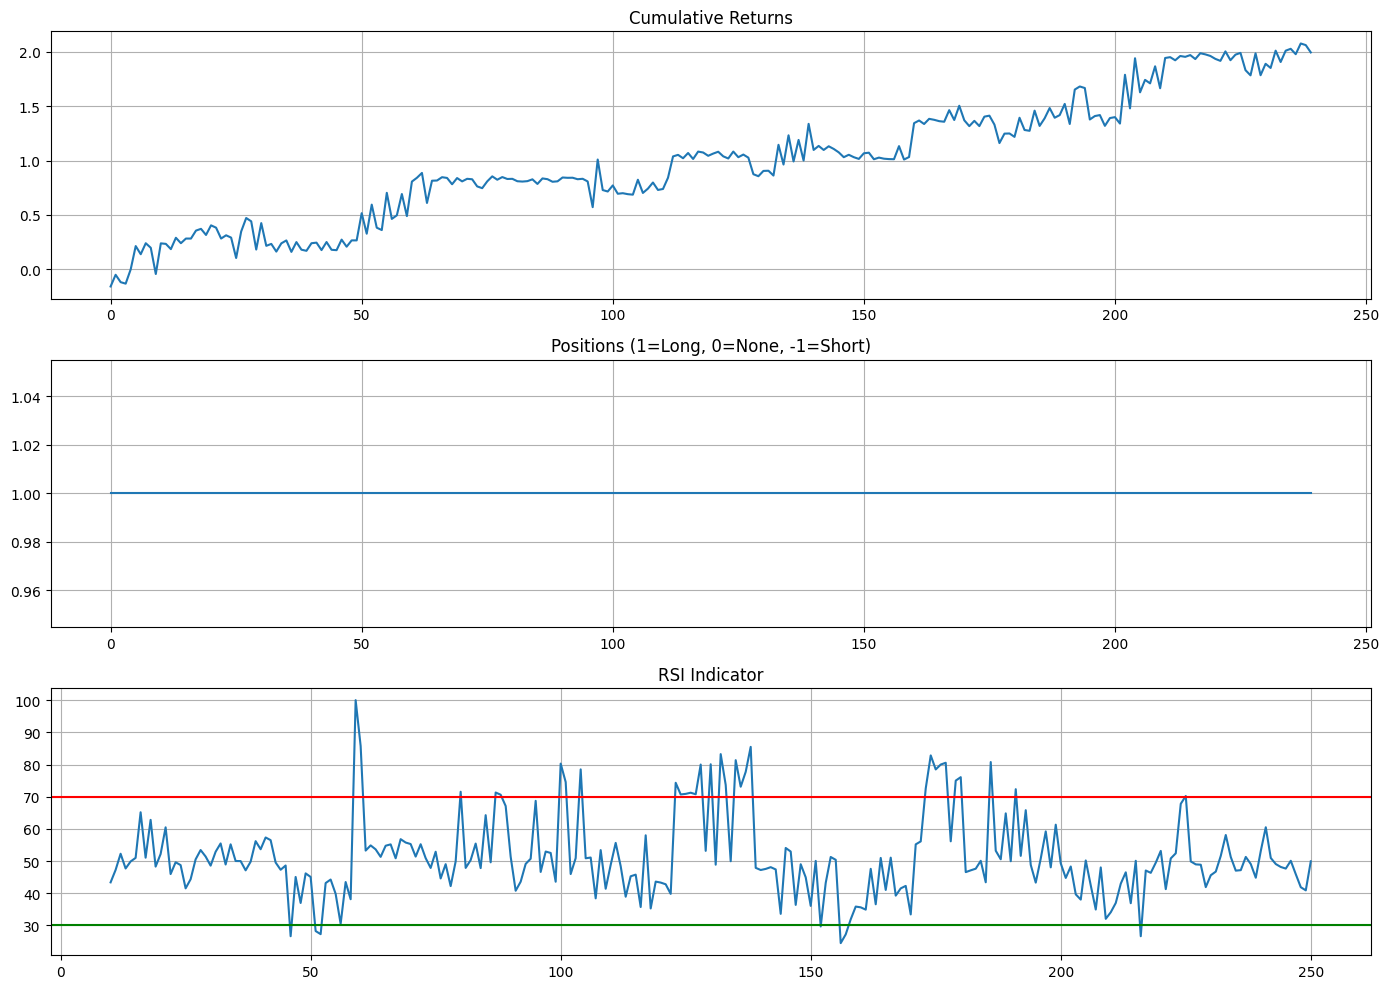

Model saved successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset, Dataset
from collections import deque
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# First check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preprocessing for deep learning
class FinancialDataPreprocessor:
    def __init__(self, window_size=10): # leads to 10x10 matrix
        self.window_size = window_size
        self.scaler = StandardScaler()

    def create_sequences(self, df):
        """Transform dataframe into sequences for training"""
        # Separate features and target
        X = df.drop(['forward_return', 'Unnamed: 0'], axis=1, errors='ignore').values
        y = df['forward_return'].values

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Create sequences
        X_sequences = []
        y_sequences = []

        for i in range(len(X_scaled) - self.window_size):
            X_sequences.append(X_scaled[i:i+self.window_size])
            y_sequences.append(y[i+self.window_size])

        return np.array(X_sequences), np.array(y_sequences)

    def boolean_to_int(self, df):
        """Convert boolean columns to integers for PyTorch compatibility"""
        for col in df.select_dtypes(include=['bool']).columns:
            df[col] = df[col].astype(int)
        return df

# Custom PyTorch Dataset for financial time series
class FinancialTimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Self-Attention Module for Time Series
class TimeSeriesSelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, dropout=0.1):
        super(TimeSeriesSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=input_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(input_dim) # normalize the layer for better stability
        self.norm2 = nn.LayerNorm(input_dim)#  same thing as above but used somewhere else
        self.ffn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # initialize a fully connected linear layer, output = input@weight.T + Bias
            nn.ReLU(),   # introduce non linearity
            nn.Dropout(dropout), #reduce over fitting
            nn.Linear(hidden_dim, input_dim), # initialize another linear layer
            nn.Dropout(dropout) # reduce overfitting
        )

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x) # checks for relations in between the input itself which is key, val and pair all the inputs are the same
        x = self.norm1(x + attn_output) # applies the normalization to this

        # Feed forward
        ffn_output = self.ffn(x) #applies ffn t
        x = self.norm2(x + ffn_output) # residual network , o/p of ffn is added to x , bu residual network captures the diff between actual and predicted

        return x

# Advanced Actor Network with Attention
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, seq_length, action_dim=3, hidden_dim=128):
        super(ActorNetwork, self).__init__() # each vector from ffn is an input channel

        # Feature extraction with 1D convolutions
        self.conv_features = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1), #padding the output
            nn.BatchNorm1d(hidden_dim), # normalize
            nn.LeakyReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1), # 1d conv
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )

        # Attention layer
        self.attention = TimeSeriesSelfAttention( # capture dependencies this is why we use self.attention
            input_dim=hidden_dim,
            hidden_dim=hidden_dim*2, # make the field more and then allow more learning
            num_heads=4 # capturing relationships
        )

        # Position-wise features
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        # Decision layers for buy,sell or hold
        self.decision = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim), # reduces the output dim
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, action_dim)
        )

        # Market regime awareness layer
        self.regime_awareness = nn.Sequential(
            nn.Linear(input_dim*seq_length, hidden_dim), # seq_length is flattened input, # different market conditions
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

        # Mean reversion signal detector
        self.mr_detector = nn.Sequential(
            nn.Linear(input_dim*seq_length, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim)
        )

        # Apply weight initialization
        self._init_weights()

    def _init_weights(self):
        """Initialize weights properly for stable training"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        batch_size, seq_len, features = x.size()

        # Apply 1D convolutions
        x_reshaped = x.permute(0, 2, 1)  # [batch, features, seq_len]
        conv_out = self.conv_features(x_reshaped)
        conv_out = conv_out.permute(0, 2, 1)  # [batch, seq_len, hidden_dim]

        # Apply attention
        att_out = self.attention(conv_out)

        # Apply LSTM
        lstm_out, _ = self.lstm(att_out)
        lstm_features = lstm_out[:, -1, :]  # Get last sequence output

        # Flatten for regime awareness
        flat_input = x.reshape(batch_size, -1)
        regime_out = self.regime_awareness(flat_input) # output for the type of network
        mr_signal = self.mr_detector(flat_input) # mean reversion signal

        # Combine decision signals
        decision_out = self.decision(lstm_features) # decision on buy sell and hold

        # Ensemble the outputs with weighted averaging - ensure equal representation
        combined_out = decision_out + 0.3 * regime_out + 0.3 * mr_signal

        # Make sure all action types have a chance to be selected
        # Add small noise to break symmetry and encourage exploration of all actions
        if self.training:
            noise = torch.randn_like(combined_out) * 0.01
            combined_out = combined_out + noise

        # Action probabilities with numerical stability
        return F.softmax(combined_out, dim=-1)

# Advanced Critic Network with Value Distribution
class CriticNetwork(nn.Module):
    def __init__(self, input_dim, seq_length, num_quantiles=10, hidden_dim=128): # quantiles because you want to pick a range of values
        super(CriticNetwork, self).__init__()

        # Feature extraction with 1D convolutions
        self.conv_features = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )

        # Attention layer
        self.attention = TimeSeriesSelfAttention(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim*2,
            num_heads=4
        )

        # Recurrent layer
        self.gru = nn.GRU( # process sequential data
            hidden_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        # Value estimation layers - distributional approach
        self.num_quantiles = num_quantiles
        self.value_quantiles = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, num_quantiles)
        )

        # Risk assessment branch
        self.risk_assessment = nn.Sequential(
            nn.Linear(input_dim*seq_length, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        # Apply weight initialization
        self._init_weights()

    def _init_weights(self):
        """Initialize weights properly for stable training"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        batch_size, seq_len, features = x.size()

        # Apply 1D convolutions
        x_reshaped = x.permute(0, 2, 1)  # [batch, features, seq_len]
        conv_out = self.conv_features(x_reshaped)
        conv_out = conv_out.permute(0, 2, 1)  # [batch, seq_len, hidden_dim]

        # Apply attention
        att_out = self.attention(conv_out)

        # Apply GRU
        gru_out, _ = self.gru(att_out)
        gru_features = gru_out[:, -1, :]  # Get last sequence output

        # Value quantiles
        quantiles = self.value_quantiles(gru_features)

        # Risk assessment
        flat_input = x.reshape(batch_size, -1)
        risk = self.risk_assessment(flat_input)

        # Return quantiles for distributional RL and risk assessment
        return quantiles, risk

# Experience buffer for off-policy learning
class ReplayBuffer:
    def __init__(self, capacity=10000): # create an empty buffer( array of size 10k)
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done)) # add experiences

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # random sampling
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)

# PyTorch Lightning module for the Actor-Critic
class TransformerActorCritic(pl.LightningModule):
    def __init__(self, state_dim, seq_length, action_dim=3, hidden_dim=128,
                 gamma=0.99, lr=1e-4, num_quantiles=10):
        super(TransformerActorCritic, self).__init__()

        self.automatic_optimization = False

        self.actor = ActorNetwork(state_dim, seq_length, action_dim, hidden_dim)
        self.critic = CriticNetwork(state_dim, seq_length, num_quantiles, hidden_dim)

        self.target_critic = CriticNetwork(state_dim, seq_length, num_quantiles, hidden_dim)
        self.update_target_network(tau=1.0)  # Initialize with same weights

        self.replay_buffer = ReplayBuffer(capacity=50000)
        self.action_dim = action_dim
        self.gamma = gamma
        self.lr = lr
        self.num_quantiles = num_quantiles

        # Quantile fractions for distributional critic
        self.quantile_fractions = torch.tensor(
            [(i * 2.0 + 1) / (2.0 * num_quantiles) for i in range(num_quantiles)],
            device=self.device
        )

        # Trading statistics
        self.total_trades = 0
        self.successful_trades = 0
        self.cumulative_return = 0

        # Action balance tracker for debugging
        self.action_counts = [0, 0, 0]  # Count of buy, hold, sell actions

        # Save hyperparameters for logging
        self.save_hyperparameters()

    def forward(self, state):
        """Forward pass through actor to get action probabilities"""
        return self.actor(state)

    def select_action(self, state, exploration=True):
        """Select action based on current policy"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action_probs = self.actor(state_tensor)

        if exploration:
            # Sample from the probability distribution
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample().item()
        else:
            # Take most probable action
            action = torch.argmax(action_probs, dim=1).item()

        # Log action for debugging
        self.action_counts[action] += 1

        return action

    def huber_quantile_loss(self, target, pred, quantile_fractions):
        """Quantile Huber loss for distributional critic"""
        n_quantiles = quantile_fractions.size(0)
        pred = pred.unsqueeze(2)
        target = target.unsqueeze(1)

        # Compute Huber loss
        huber_loss = F.smooth_l1_loss(pred, target.expand_as(pred), reduction='none')

        # Compute quantile loss
        error = target - pred
        quantile_weight = torch.abs(quantile_fractions.unsqueeze(1) - (error < 0).float())

        return (quantile_weight * huber_loss).mean()

    def update_target_network(self, tau=0.005):
        """Soft update of target network"""
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def configure_optimizers(self):
        """Configure optimizers for actor and critic with lower learning rates"""
        actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr/10)
        critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr/5)

        return [actor_optimizer, critic_optimizer]

    def training_step(self, batch, batch_idx):
        """Training step for supervised learning with gradient clipping"""
        # Unpack the batch (features and target)
        X, y = batch

        # Get optimizers
        actor_optimizer, critic_optimizer = self.optimizers()

        # Actor update
        actor_optimizer.zero_grad()
        action_probs = self.actor(X)

        # Create target actions - for simplified training, we'll create target actions
        # based on the sign of returns (positive return → buy, negative → sell, near zero → hold)
        target_actions = torch.zeros(y.size(0), dtype=torch.long, device=self.device)

        # Buy (0) for positive returns above threshold
        target_actions[y.squeeze() > 0.005] = 0

        # Sell (2) for negative returns below threshold
        target_actions[y.squeeze() < -0.005] = 2

        # Hold (1) for returns near zero
        target_actions[(y.squeeze() >= -0.005) & (y.squeeze() <= 0.005)] = 1

        # Calculate actor loss with numerical stability
        actor_loss = F.cross_entropy(action_probs + 1e-8, target_actions)

        # Manual backward for actor loss
        self.manual_backward(actor_loss)

        # Apply gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)

        actor_optimizer.step()

        # Critic update
        critic_optimizer.zero_grad()
        quantiles, risk = self.critic(X)

        # Calculate critic loss with numerical stability
        critic_loss = F.mse_loss(quantiles.mean(dim=1), y + 1e-8)

        # Manual backward for critic loss
        self.manual_backward(critic_loss)

        # Apply gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)

        critic_optimizer.step()

        # Log losses and action distribution
        self.log('actor_loss', actor_loss, prog_bar=True)
        self.log('critic_loss', critic_loss, prog_bar=True)

        # Log action distributions to monitor balance
        with torch.no_grad():
            action_distribution = action_probs.mean(dim=0)
            self.log('buy_prob', action_distribution[0], prog_bar=False)
            self.log('hold_prob', action_distribution[1], prog_bar=False)
            self.log('sell_prob', action_distribution[2], prog_bar=False)

        return {"loss": actor_loss + critic_loss}

    def on_train_epoch_end(self):
        """Log action balance at the end of each epoch"""
        total_actions = sum(self.action_counts)
        if total_actions > 0:
            buy_pct = self.action_counts[0] / total_actions * 100
            hold_pct = self.action_counts[1] / total_actions * 100
            sell_pct = self.action_counts[2] / total_actions * 100

            self.log('buy_pct', buy_pct, prog_bar=True)
            self.log('hold_pct', hold_pct, prog_bar=True)
            self.log('sell_pct', sell_pct, prog_bar=True)

            # Reset counts for next epoch
            self.action_counts = [0, 0, 0]

    def on_validation_epoch_end(self):
        """Calculate and log validation metrics"""
        self.log('win_rate', self.successful_trades / max(1, self.total_trades), prog_bar=True)
        self.log('cumulative_return', self.cumulative_return, prog_bar=True)

# Trading environment for mean reversion
class MeanReversionTradingEnv:
    def __init__(self, data, window_size=10, transaction_cost=0.001):
        self.data = data
        self.window_size = window_size
        self.transaction_cost = transaction_cost
        self.reset()

    def reset(self):
        """Reset the environment"""
        self.current_step = self.window_size
        self.position = 0  # 0: no position, 1: long, -1: short
        self.returns = []
        return self._get_state()

    def step(self, action):
        """Take a step in the environment"""
        # Action: 0 (Buy), 1 (Hold), 2 (Sell)
        reward = 0
        done = False

        current_price = self.data['Close_Lag_2'].iloc[self.current_step]
        next_price = self.data['Close_Lag_2'].iloc[self.current_step + 1] if self.current_step + 1 < len(self.data) else current_price

        # Calculate price change
        price_change = (next_price - current_price) / current_price

        # Execute action
        if action == 0:  # Buy
            if self.position == 0:
                self.position = 1
                reward = -self.transaction_cost
            elif self.position == -1:  # Close short position
                reward = -price_change - self.transaction_cost
                self.position = 0

        elif action == 2:  # Sell
            if self.position == 0:
                self.position = -1
                reward = -self.transaction_cost
            elif self.position == 1:  # Close long position
                reward = price_change - self.transaction_cost
                self.position = 0

        # Update reward based on current position
        if self.position == 1:
            reward += price_change
        elif self.position == -1:
            reward += -price_change

        # Update step
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True

        # Save return
        self.returns.append(reward)

        # Get new state
        next_state = self._get_state()

        return next_state, reward, done, {}

    def _get_state(self):
        """Get current state representation"""
        features = self.data.drop(['forward_return', 'Unnamed: 0'], axis=1, errors='ignore')
        features = features.iloc[self.current_step-self.window_size:self.current_step].values
        return features

# Training function
def train_mean_reversion_model(df, epochs=50, batch_size=64, window_size=10):
    """Train the transformer-enhanced actor-critic model"""
    # Preprocess data
    preprocessor = FinancialDataPreprocessor(window_size=window_size)
    df = preprocessor.boolean_to_int(df)
    X_sequences, y_sequences = preprocessor.create_sequences(df)

    # Create dataset and dataloader
    dataset = FinancialTimeSeriesDataset(X_sequences, y_sequences)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    state_dim = X_sequences.shape[2]  # Number of features
    model = TransformerActorCritic(
        state_dim=state_dim,
        seq_length=window_size,
        action_dim=3,  # Buy, Hold, Sell
        hidden_dim=128,
        gamma=0.99,
        lr=1e-5,  # Lower learning rate
        num_quantiles=15
    )

    # Setup callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='mean_reversion_model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min'
    )

    early_stop_callback = EarlyStopping(
        monitor='critic_loss',
        patience=10,
        mode='min'
    )

    # Train with PyTorch Lightning
    trainer = pl.Trainer(
      max_epochs=epochs,
      accelerator="gpu" if torch.cuda.is_available() else "cpu",
      devices=1 if torch.cuda.is_available() else None,
      callbacks=[checkpoint_callback, early_stop_callback],
      # Also note: progress_bar_refresh_rate is replaced with enable_progress_bar
      enable_progress_bar=True,
      # Add global gradient clipping as an extra safety measure
    )

    trainer.fit(model, train_loader, val_loader)

    return model, preprocessor

# Backtest the model on test data
def backtest_model(model, df, window_size=10, transaction_cost=0.001):
    """Backtest the trained model"""
    env = MeanReversionTradingEnv(df, window_size, transaction_cost)
    state = env.reset()

    done = False
    total_reward = 0
    positions = []
    rewards = []
    actions_taken = [0, 0, 0]  # Count of [buy, hold, sell] actions

    while not done:
        # Select action with exploration turned off
        action = model.select_action(state, exploration=False)

        # Track action distribution
        actions_taken[action] += 1

        # Take step in environment
        next_state, reward, done, _ = env.step(action)

        # Track metrics
        total_reward += reward
        positions.append(env.position)
        rewards.append(reward)

        # Update state
        state = next_state

    # Calculate performance metrics
    cumulative_returns = np.cumsum(rewards)
    sharpe_ratio = np.mean(rewards) / (np.std(rewards) + 1e-9) * np.sqrt(252)
    max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))

    print(f"Total Return: {total_reward:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown:.4f}")
    print(f"Action distribution: Buy: {actions_taken[0]}, Hold: {actions_taken[1]}, Sell: {actions_taken[2]}")

    # Plot results
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(cumulative_returns)
    plt.title('Cumulative Returns')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(positions)
    plt.title('Positions (1=Long, 0=None, -1=Short)')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(df['RSI'].iloc[window_size:])
    plt.axhline(y=30, color='g', linestyle='-')
    plt.axhline(y=70, color='r', linestyle='-')
    plt.title('RSI Indicator')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'total_return': total_reward,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'positions': positions,
        'rewards': rewards,
        'actions_taken': actions_taken
    }

# Main execution
if __name__ == "__main__":
    # Load pruned dataframe
    df = pd.read_csv('/content/pruned_df.csv')

    # Convert boolean columns to integers
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype(int)

    # Train model
    print("Training Transformer-Enhanced Actor-Critic Model...")
    model, preprocessor = train_mean_reversion_model(
        df,
        epochs=50,
        batch_size=16,
        window_size=10
    )

    # Backtest model
    print("\nBacktesting Model...")
    backtest_results = backtest_model(model, df)

    # Save model
    torch.save(model.state_dict(), 'mean_reversion_model.pth')
    print("Model saved successfully!")

In [ ]:
pruned_df.columns